## Show results - Test 

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'

2020-11-03 16:14:16,407 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


## Damage cost for each scenario, year and age category

In [2]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

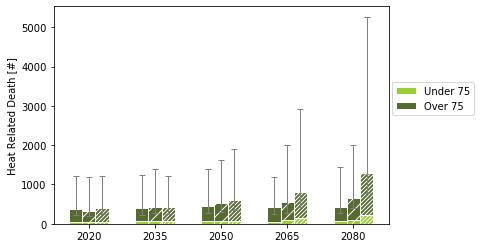

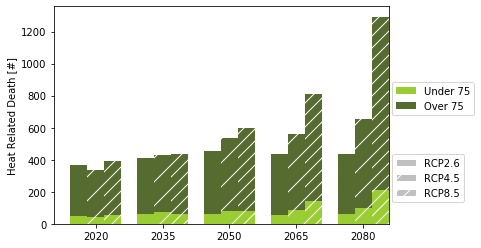

In [3]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat Related Death [#]', color=['yellowgreen', 'darkolivegreen'])

## Spatial Impact

In [4]:
from src.write_entities.define_exposures import *

directory_exposures = '../../input_data/exposures/'
file_info='../../input_data/exposures/age_categories.csv'
file_locations='../../input_data/exposures/STATPOP2018.csv'
shp_cantons='../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'
annual_deaths='../../input_data/impact_functions/annual_deaths.xlsx'

exposures_all = call_exposures_switzerland_mortality(file_info, file_locations, shp_cantons, annual_deaths, population_ratio=False) #number of people instead of ratio


2020-11-03 16:14:21,790 - climada.util.coordinates - INFO - Setting geometry points.
2020-11-03 16:15:33,417 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-11-03 16:20:38,165 - climada.util.coordinates - INFO - Setting geometry points.
2020-11-03 16:21:22,657 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


In [7]:
exposures = exposures_all[exposures_all['category']=='Over 75']
exposures = Exposures(exposures)
len(exposures)

344419

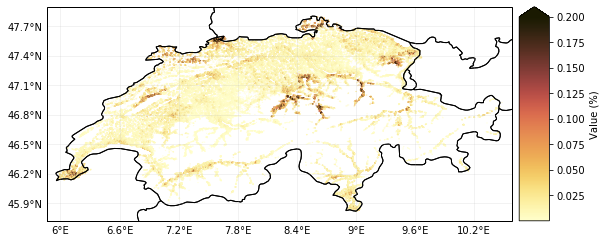

In [11]:
pickle_in = \
open('../../output/mortality_results/impact_100mc2.pickle','rb')
impacts_mortality = pickle.load(pickle_in)


exposures = exposures_all[exposures_all['category']=='Over 75']
exposures = Exposures(exposures)

category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures, unit='%', percentage=True)
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=0.2, extend='max')

#plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

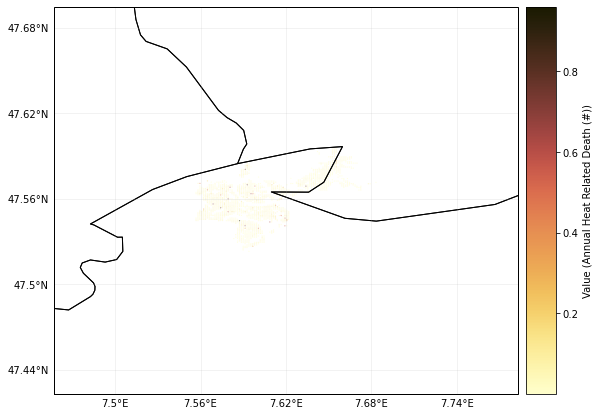

In [6]:
impact = impacts_mortality.matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

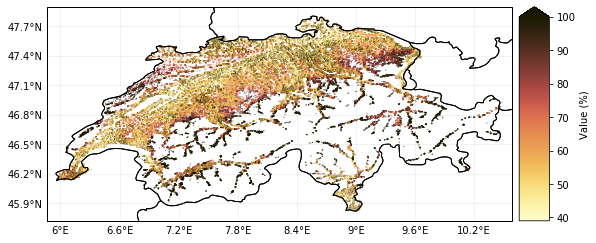

In [17]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures, unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

#plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

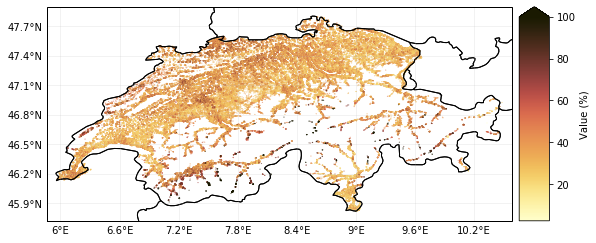

In [19]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP26'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures, unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

#plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

## Canton Impacts

In [8]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices

directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures)


2020-10-29 14:15:21,441 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-10-29 14:15:23,195 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-29 14:15:23,196 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-29 14:15:23,197 - climada.entity.exposures.base - INFO - cover not set.
2020-10-29 14:15:23,197 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-29 14:15:23,198 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-29 14:15:23,200 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-10-29 14:15:25,354 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-29 14:15:25,356 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-29 14:15:25,357 - climada.entity.exposures.base - INFO - cover not set.
2020-10-29 14:15:25,357 - climada.entity.exposures.base - INFO - category_id not s

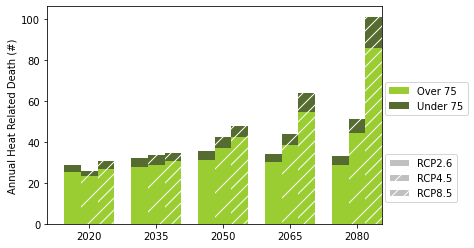

In [9]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)', uncertainty=False, color=['yellowgreen', 'darkolivegreen'])

